In [1]:
import torch
import matplotlib.pyplot as plt
import math

from renderer import project_gaussians, rasterize_gaussians
from utils import ellipse_ndim

from matplotlib.patches import Polygon

import numpy as np

### Data

In [2]:
N = 10

mu = (torch.rand((N,3)) - 0.5) * 4.
scale = torch.rand((N,3)) * 0.2
quat = torch.rand((N, 4))
col = torch.rand((N, 3))
opc = torch.rand((N,))

### Projection

In [3]:
# Output Image Width and Height
W = 1920
H = 1080 

In [4]:
fov_x = math.pi / 2.0 # Angle of the camera frustum 90°
focal = 0.5 * float(W) / math.tan(0.5 * fov_x) # Distance to Image Plane

viewmat = torch.eye(4)
viewmat[:3,3] = torch.tensor([0,0,-4])

In [5]:
(
    mu_,
    cov_,
    z
) = project_gaussians(
    means3d=mu,
    scales=scale,
    quats=quat,
    viewmat=viewmat,
    fx=focal,
    fy=focal,
    cx=W/2,
    cy=H/2,
    img_height=H,
    img_width=W
)

(0.0, 1080.0)

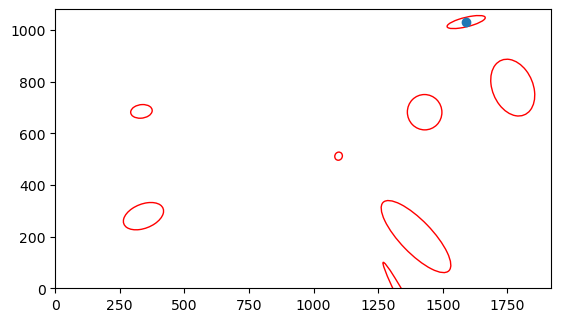

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ellipse_ndim(mu_, cov_, ax, edgecolor='red')
ax.scatter(mu_[0,0], mu_[0,1])

ax.set_aspect('equal', adjustable='box')
ax.set_xlim([0,W])
ax.set_ylim([0,H])

##################################

### Rendering

In [7]:
out_img = rasterize_gaussians(
    xys=mu_,
    depths=z,
    covs=cov_,
    conics=None,
    num_tiles_hit=None,
    colors=col,
    opacity=opc,
    img_height=H,
    img_width=W,
    block_width=None,
    background=None,
    return_alpha=None
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


(0.0, 1080.0)

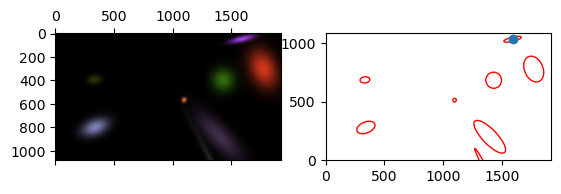

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.scatter(mu_[0,0], mu_[0,1])
# ax2.scatter(mu_[1,0], mu_[1,1])
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

### Tiling (SAT)

$\Sigma_2 = \begin{bmatrix} a & b \\ b & d \end{bmatrix}$

Eigenvalues: \
    $\lambda_1 = \frac{a + d + \sqrt{(a-d)^2 + 4b^2}}{2}$ \
    $\lambda_2 = \frac{a + d - \sqrt{(a-d)^2 + 4b^2}}{2}$

In [9]:
def get_eigenvalues(cov):
    a = cov[:,0,0]; b = cov[:,0,1]; d = cov[:,1,1]

    A = torch.sqrt(a*a - 2*a*d + 4*b**2 + d*d)
    B = a + d

    return 0.5 * (A + B), 0.5 * (-A + B)

$r_1 = 3\sqrt{\lambda_1}$ \
$r_2 = 3\sqrt{\lambda_2}$

In [10]:
def get_radii(cov):
    eigs = get_eigenvalues(cov)
    l1, l2 = eigs[0], eigs[1]
    return 1 * torch.sqrt(l1), 1 * torch.sqrt(l2) # TODO: change to 3 * sigma

In [22]:
def get_orientation(cov):
    a = cov[:,0,0]; b = cov[:,0,1]; c = cov[:,1,1]
    eigs = get_eigenvalues(cov)
    l1 = eigs[0]

    theta = torch.zeros_like(a)
    theta[(b == 0) & (a >= c)] = torch.pi/2
    theta[b != 0] = torch.atan2(l1 - a, b)

    return theta

    # if b == 0:
    #     if a >= c:
    #         return torch.tensor(0.)
    #     else:
    #         return torch.tensor(torch.pi/2)
    # else:
    #     return torch.atan2(l1 - a, b)


In [35]:
def get_rotation(theta):
    cos = torch.cos(theta)
    sin = torch.sin(theta)

    R = torch.empty((len(cos),2,2))
    R[:,0,0] = cos
    R[:,0,1] = -sin
    R[:,1,0] = sin
    R[:,1,1] = cos

    return R

    # return torch.tensor([
    #     [cos, -sin],
    #     [sin,  cos]
    # ])

In [36]:
def get_box(mu, cov):
    N = len(mu)

    r1, r2 = get_radii(cov)

    B = torch.empty((N, 4, 2))

    B[:,0,0] = mu[:,0] - r1; B[:,0,1] = mu[:,1] + r2
    B[:,1,0] = mu[:,0] + r1; B[:,1,1] = mu[:,1] + r2
    B[:,3,0] = mu[:,0] - r1; B[:,2,1] = mu[:,1] - r2
    B[:,2,0] = mu[:,0] + r1; B[:,3,1] = mu[:,1] - r2
    
    return B

In [37]:
theta = get_orientation(cov_)
rot = get_rotation(theta)
theta

tensor([0.2385, 1.1339, 0.3779, 2.3349, 2.6334, 1.9726, 0.1322, 1.7329, 0.0216,
        2.0561])

In [42]:
box = get_box(mu_, cov_)
box_mean = box.mean(dim=1, keepdim=True)
box.shape

torch.Size([10, 4, 2])

In [46]:
rot.shape, box.shape, box_mean.shape, (box - box_mean).shape

(torch.Size([10, 2, 2]),
 torch.Size([10, 4, 2]),
 torch.Size([10, 1, 2]),
 torch.Size([10, 4, 2]))

In [48]:
rot_box = (rot @ (box - box_mean).permute((0,2,1))).permute((0,2,1)) + box_mean

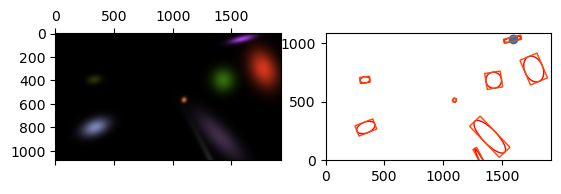

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.scatter(mu_[0,0], mu_[0,1])
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

for box in rot_box:
 ax2.add_patch(Polygon(box, fc='none', ec='orangered'))

### Tiling

In [24]:
W, H

(1920, 1080)